In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Calibration parameters

| Run |  Energy (GeV)|  Magnet current (A)|
|-----|:---:|:-----:|
| 260 | 22 | -580 |
| 261 | 18 | -850 |
| 262 | 18 |  850 |
| 263 | 22 |  580 |

# Class hit
Every hit recorded in each Event.
Each hit has these properties:

-chamber, which of the four detector registered the hit (numbering is in the range $0-4$)

-layer, which layer of that detector

-xleft, the x position of the hit in the local detector coordinates assuming the track passed
at the left of the wire

-xright, the x position of the hit in the local detector coordinates assuming the track passed at the right of the wire

-time, the drift time (redundant)

In [13]:
#To eliminate?
    # Cell dimensions
XCELL = 42.
ZCELL = 13.

    # X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

    # Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]


class hit:

    def __init__(self, num, reading):
        self.number = num
        self.chamber = int(reading[0])
        self.layer = int(reading[1])
        self.xleft = float(reading[2])
        self.xright = float(reading[3])
        self.time = float(reading[4])
        #derived features
        self.xleft_global, self.xright_global, self.z_global = self.global_coord()
        
    def describe(self):
        print("Hit number:",self.number)
        print("Chamber:",self.chamber)
        print("Layer:",self.layer)
        
    # convert local coordinates to global coord. using the chamber and layer number   
    # TO BE CHECKED!
    def global_coord(self):
        x_global_left = self.xleft - global_x_shifts[self.chamber]
        x_global_right = self.xright - global_x_shifts[self.chamber]
        #layer is a 1-4 number, index start at 0 (must add -1)
        z_global = local_z_shifts[self.layer-1] + global_z_shifts[self.chamber]       
        return x_global_left, x_global_right, z_global

In [28]:
class event:
    def __init__(self, reading):
        self.number = int(reading[0])
        self.Nhits = int(reading[1])
        #Pandas DataFrame objects
        self.df = self.create_df(reading[2:])
        #now useless
        self.hits = self.load_hits(self.Nhits,reading[2:])
    
    #create event dataframe from file row
    def create_df(self,reading):
        col_names = ["N_hit","Chamber","Layer","xleft","xright","time"]
        data = [[i]+reading[5*i:5*(i+1)] for i in range(self.Nhits)]
        df = pd.DataFrame(data = data,columns = col_names)
        return df
    
    #create list of class hit <--- now useless
    def load_hits(self,N,reading):
        hits = []
        if N == 0:
            return hits
        for i in range(N):
            #Every hit contains 5 features without counting the hit number
            hits.append( hit( i, reading[5*i:5*(i+1)]) )
        return hits   
    
    def describe(self):
        print("Event number:",self.number)
        print("Number of hits recorded:",self.Nhits)
        return

In [29]:
class run:
    def __init__(self,filename):
        self.filename = filename
        self.Nevents, self.Events = self.load_run(filename)
    
    def load_run(self,filename): 
        run = []
        with open(filename) as fp:
            for cnt, line in enumerate(fp):
                run.append(event(line.split()))
        return len(run), run  
    
    

In [30]:
#Loading a calibration file
run260 = run("calibration/Run000260/data_000000.txt")

In [35]:
run260.Events[3].df

,N_hit,Chamber,Layer,xleft,xright,time
0,0,0,1,6.501e+02,6.519e+02,15.8
1,1,2,2,1.658e+02,1.702e+02,41.7
2,2,2,4,1.606e+02,1.754e+02,137.5
3,3,2,1,1.277e+02,1.663e+02,359.2
4,4,2,3,1.318e+02,1.622e+02,282.5
5,5,3,2,4.056e+01,4.344e+01,26.7
6,6,3,1,1.395e+01,2.805e+01,130.8
7,7,3,4,3.531e+01,4.869e+01,124.2
8,8,3,3,1.853e+01,2.347e+01,45.8
9,9,3,2,2.594e+01,5.806e+01,298.3


In [221]:
#Getting points in the xz global plane 
#    just selecting the right variables in the classes
import itertools

left = [i.xleft_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []]))]
right = [i.xright_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []]))]
z = [i.z_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []]))]

Text(0.5, 1.0, 'Detectors Hits')

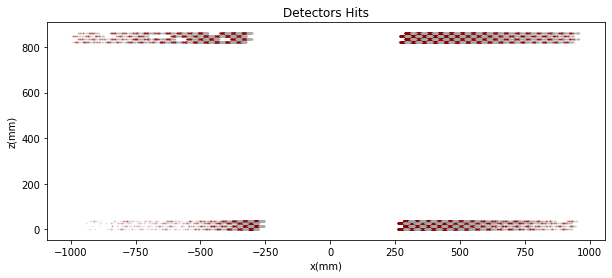

In [222]:
#Dysplay chambers
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(left,z,c="darkred",marker="o", s = 1, alpha=0.1)
ax.scatter(right,z,c="darkgray",marker="o",s = 1,alpha=0.1)
ax.set_xlabel("x(mm)")
ax.set_ylabel("z(mm)")
plt.title("Detectors Hits")

In [218]:
#Getting only left chambers hits (chamber 0 & 1)
left = [i.xleft_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []])) if i.chamber < 2]
right = [i.xright_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []])) if i.chamber < 2]
z = [i.z_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []])) if i.chamber < 2]

Text(0.5, 1.0, 'Left detectors hits')

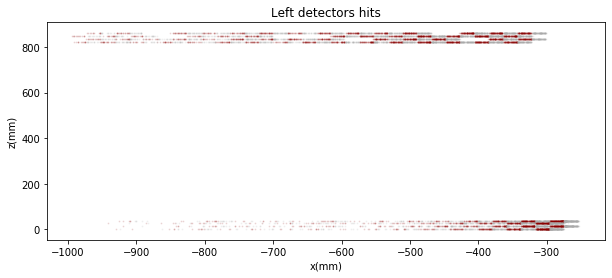

In [219]:
#Display left chambers
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(left,z,c="darkred",marker="o", s = 1, alpha=0.1)
ax.scatter(right,z,c="darkgray",marker="o",s = 1,alpha=0.1)
ax.set_xlabel("x(mm)")
ax.set_ylabel("z(mm)")
plt.title("Left detectors hits")

In [282]:
#Display only one event
number = 6
left = [hit.xleft_global for hit in run260.Events[number].hits]
right = [hit.xright_global for hit in run260.Events[number].hits]
z = [hit.z_global for hit in run260.Events[number].hits]

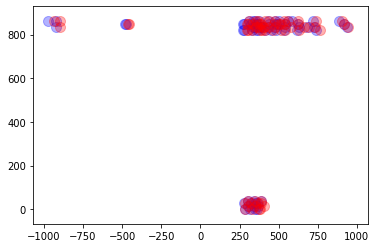

In [283]:
plt.scatter(left,z,c="blue",alpha = 0.3,s = 100 )
plt.scatter(right,z,c="red",alpha = 0.3,s = 100)

In [223]:
#Getting only "Good" Events, at least 3 hits in 3 different layers into one chamber
#To be modified with smarter ways, using pandas
Good_events = []
Good_hits = []
#cicle over events
for event in run260.Events:
    if event.Nhits > 2:
        #cycle over detectors
        for det in range(4):
            layers = []
            hits = []
            for hit in event.hits:
                if hit.chamber == det:
                    hits.append(hit)
                    if hit.layer not in set(layers):
                        layers.append(hit.layer) 
            #if registered at least 3 hits in 3 layers            
            if len(layers) > 2:
                Good_events.append(event)
                Good_hits.append(hits)
                


In [228]:
#Local fit in each chamber ( o detector)
fits = []
for detector in range(4):
    cfit = []
    for hit_g in Good_hits:
        left = [i.xleft_global for i in hit_g if i.chamber == detector]
        right = [i.xright_global for i in hit_g if i.chamber == detector]      
        z = [i.z_global for i in hit_g if i.chamber == detector]
        
        #middle point between left and right ???? don't know what left-right ambiguity means
        x = [(i+j)/2.0 for i,j in zip(left,right)]
        
        if len(x) > 2:
            cfit.append(np.polyfit(x,z,deg = 1))
    fits.append(cfit)    

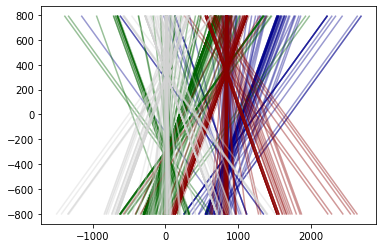

In [271]:
color = ["darkblue","darkgreen","darkred","lightgray"]
i = 0
for fr in fits:
    for f in fr[:100]:
        x = np.arange(-800,800,10)
        plt.plot(f[0]*x+f[1],x,color[i],alpha = 0.4)
    i+=1    